# Assignment 3: LDA Topic Modeling

## Note
Installing Tomotopy locally can return an error, if that's the case run this notebook on Google Colab

## Research Background

LDA is a popular topic modeling algorithm widely used in the fields of Digital Humanities and Social Sciences. In the field of political communication, topic modeling is often applied for analyzing politicians Twitter/X posts, identitying thematic patterns or topics revolving around their posts.

For this assignment, students will work with tweets from two USA politicians, Donald Trump and Bernie Sanders, who are often regarded as right-wing populist and left-wing populist respectively. Right-wing populism often emphasizes nationalism, anti-immigration policies, and a critique of global elites from a culturally conservative perspective, focusing on preserving traditional values and social hierarchies. Left-wing populism prioritizes economic inequality, advocating for the redistribution of wealth, expansion of social services, and empowerment of the working class against the capitalist elite. While both forms of populism appeal to the "common people" against perceived elites and established structures, they diverge significantly in their identification of the elites, proposed solutions, and core ideologies. For a more detailed explanation, you can read the chapter by Macaulay (2019) "Bernie and The Donald: A comparison of left-and right-wing populist discourse" (full reference below).

**Research Questions**
1. What topics are revolving around Donald Trump and Bernie Sanders' posts separately?
2. What are the topic differences between Trump (right-wing popoulist) and Sanders (left-wing populist)?

**Aim:**
1. The first aim of the assignment is to conduct LDA topic modeling. Identify thematic patterns or politics revolving around Trump or Sanders's posts.
2. The second aim is to critically evaluate the results of topic modeling. Try different numbers of topics to see with which settings the topics are more coherent. Critically reflect on the results of LDA topic modeling, discussing them in relation to existing theories about populism.

**Data**
Two datasets are prepared for this assginment. Tweets from Trump and tweets from Sanders. Students are asked to work on these two datasets.

**Methods**
1. Word segamentation
2. Removing stopwords
3. LDA topic modeling
4. Topic evaulation (coherence and human evaluation)
5. Visualization of results.

**References**
1. Macaulay, M. (2019). Bernie and the Donald: A comparison of Left-and Right-wing populist discourse. *Populist discourse: International perspectives*, 165-195.





## Setup

### Q1. Install necessary libraries, including `tomotopy` and `little_mallet_wrapper`, and import them

In [28]:
# Q1 (code)
!pip install tomotopy
!pip install little_mallet_wrapper

In [29]:
import tomotopy as tp
import little_mallet_wrapper
import seaborn
import glob
from pathlib import Path
import pandas as pd
import re

## Data preprocessing

### Q2. Load the two datasets and concatenate them

The goal is to run topic modelling on the combined dataset of Sanders and Trump's tweets

In [4]:
# Q2 (code)
# Load the datasets
sanders_tweets_df = pd.read_csv('/Users/zhanghanyue/Desktop/Assignment3-AD/sanders_tweets.csv')
trump_tweets_df = pd.read_csv('/Users/zhanghanyue/Desktop/Assignment3-AD/trump_tweets.csv')

# Concatenate the datasets
combined_df = pd.concat([sanders_tweets_df, trump_tweets_df])

# Reset index
combined_df.reset_index(drop=True, inplace=True)

# Display the combined dataset
print(combined_df.head())

     Username              TweetId                           Title  \
0  SenSanders  1351670845639421952  SenSanders_1351670845639421952   
1  SenSanders  1351259762722279424  SenSanders_1351259762722279424   
2  SenSanders  1351242822293319680  SenSanders_1351242822293319680   
3  SenSanders  1350885541911400448  SenSanders_1350885541911400448   
4  SenSanders  1349880150041780224  SenSanders_1349880150041780224   

                                             Content  
0  Wealth increase in past 10 months:\n⬆️$173 bil...  
1  Amidst massive income and wealth inequality te...  
2  “We now have the resources, we now have the sk...  
3  After surviving an attempt on his life, Russia...  
4  President-Elect Biden's COVID rescue plan will...  


### Q3. Clean the data

Transform all tweets to lowercase, remove stopwords, punctuation, and numbers. Add the processed text to a list called `training_data`.
Create a list with the content of the tweets (`original_texts`) and a list that allows you to identify both the author of the tweet and its ID (`titles`).


In [9]:
import re
import nltk
from nltk.corpus import stopwords

# Download NLTK resources
nltk.download('stopwords')

# Initialize stopwords
stop_words = set(stopwords.words('english'))

# Initialize lists
training_data = []
original_texts = []
titles = []


def preprocess_text(text, title):
    processed_text = little_mallet_wrapper.process_string(text, numbers='remove', lowercase=True, remove_stop_words = True, remove_punctuation= True)
    processed_text = re.sub(r"http\S+|www\S+|https\S+|\/\/t|co\/|\@\w+|realdonaldtrump", '', processed_text, flags=re.MULTILINE)# Tip: add the following line to remove URLS and user mentions

    training_data.append(processed_text)
    original_texts.append(text)
    titles.append(title)
    
# Apply a text processing function to the "Content" column
combined_df.apply(lambda x: preprocess_text(x['Content'], x['Title']), axis=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhanghanyue/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0        None
1        None
2        None
3        None
4        None
         ... 
30366    None
30367    None
30368    None
30369    None
30370    None
Length: 30371, dtype: object

## LDA topic modelling

### Q4. Train a an LDA topic model with `tomotopy`

In [10]:
# Q4 (code)
# Number of topics to return
num_topics = 15
# Numer of topic words to print out
num_topic_words = 10

# Intialize the model
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

Topic Model Training...


Iteration: 0	Log-likelihood: -9.716852119877153
Iteration: 10	Log-likelihood: -9.33217421031061
Iteration: 20	Log-likelihood: -9.159599536366406
Iteration: 30	Log-likelihood: -9.070123175668877
Iteration: 40	Log-likelihood: -9.013150819578797
Iteration: 50	Log-likelihood: -8.968713738237575
Iteration: 60	Log-likelihood: -8.928989738892357
Iteration: 70	Log-likelihood: -8.90549202653021
Iteration: 80	Log-likelihood: -8.885534449080904
Iteration: 90	Log-likelihood: -8.86746181944211


### Q5. Print out the top words for each topic and manually evaluate their coherence


In [11]:
# Q5a (code)
# Print out top 10 words for each topic
print("\nTopic Model Results:\n\n")


topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")


Topic Model Results:


✨Topic 0✨

great vote total endorsement state strong military complete governor amendment

✨Topic 1✨

drug coronavirus covid federal prices americans new government testing drugs

✨Topic 2✨

trump must security president right american government people law want

✨Topic 3✨

workers pay tax women billion year wealth america wage million

✨Topic 4✨

news fake media people never even bad like cnn would

✨Topic 5✨

biden joe democrats president impeachment left radical party trump pelosi

✨Topic 6✨

must war change people climate trump energy together stand world

✨Topic 7✨

great president thank whitehouse today house white korea north meeting

✨Topic 8✨

trump president fbi russia collusion witch hunt mueller campaign schiff

✨Topic 9✨

united states trade jobs china deal world american countries big

✨Topic 10✨

great thank america president trump economy jobs ever big best

✨Topic 11✨

thank law god today nation american day enforcement whitehouse state

✨Topic 

In [12]:
# Q5b (words)
# Describe what each topic is about. What ideas, values, or situations do these keywords refer to?

topic0: This topic is about about support for the army, state leadership, and changes to the law.

topic1: This topic is about how the government is dealing with COVID-19, the cost of medicines, and the need for more tests.

topic2: This topic is about protecting the country, what the president does, and the power of the government.

topic3: This topic points out issues with how much people get paid, taxes, and the big gap between rich and poor people.

topic4: This topic is about not trusting the news, calling out "fake news," and disliking certain news channels like CNN.

topic5: This topic is about disagreements, focusing on Joe Biden, the process of impeachment, and criticism of the Democratic Party and its leaders.

topic6: This topic highlights the importance of dealing with climate change and moving to clean energy.

topic7: This topic is about the work of the president in making peace and leading, especially mentioning meetings with North Korea.

topic8: This topic is about he investigations related to President Trump, like the Russia investigation and impeachment.

topic9: This topic is about how trade with other countries affects jobs and deals with countries like China.

topic10: This topic shows pride in how the country is doing, the economy, and President Trump's leadership.

topic11: This topic highlights love for the country, support for the police, and mentions religion.

topic12: This topic is about concerns about border security, immigration laws, and criticism of the Democratic Party's stance.

topic13: This topic highlights the need for everyone to have access to healthcare and how it affects taxpayers.

topic14: This topic brings up concerns about the fairness of elections, the Supreme Court's role, and claims of voting fraud.

## Topic coherence

Use `tomotopy`'s [`.coherence()`](https://bab2min.github.io/tomotopy/v0.10.0/en/coherence.html) function to automatically calculate the topic coherence.

The coherence value can vary from `0` (no coherence) to `1` (maximum coherence). Interpret the results and, if needed, retrain the model using a different number of topics.

In [35]:
# There are different metrics for coherence, we choose `c_v`

coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.5982071907569966 
Per Topic: [0.5599535942077637, 0.6715223670005799, 0.5771613717079163, 0.5259527564048767, 0.6202085018157959, 0.5284286975860596, 0.45468672215938566, 0.6163862079381943, 0.5869125157594681, 0.5945942908525467, 0.7798858165740967, 0.5852343253791332, 0.5197227835655213, 0.7087892174720765, 0.7443579196929931, 0.5307761371135712, 0.6545405611395836, 0.5239275768399239, 0.6107257902622223, 0.580321627855301, 0.5856935858726502, 0.658256220817566, 0.5777397602796555, 0.5391548976302147, 0.5745544373989105, 0.5995805844664573, 0.5843097165226936, 0.5463583886623382, 0.662898850440979, 0.64358049929142]



In [36]:
num_topics_5 = 5

# Intialize the model
model = tp.LDAModel(k=num_topics_5)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')
# There are different metrics for coherence, we choose `c_v`

# 5 topics' result
coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence_5 = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence 5 topics: {} ===='.format('c_v'))
print('Average:', average_coherence_5, '\nPer Topic:', coherence_per_topic)
print()

Topic Model Training...


Iteration: 0	Log-likelihood: -9.344074444923457
Iteration: 10	Log-likelihood: -9.091823019958843
Iteration: 20	Log-likelihood: -8.954106679304072
Iteration: 30	Log-likelihood: -8.892896400263139
Iteration: 40	Log-likelihood: -8.860040139278365
Iteration: 50	Log-likelihood: -8.838530118566242
Iteration: 60	Log-likelihood: -8.824038525082303
Iteration: 70	Log-likelihood: -8.814194605741509
Iteration: 80	Log-likelihood: -8.804205094259347
Iteration: 90	Log-likelihood: -8.797186629910794
==== Coherence 5 topics: c_v ====
Average: 0.52034723341465 
Per Topic: [0.595923638343811, 0.4507411688566208, 0.46006378531455994, 0.515036454796791, 0.579971119761467]



In [37]:
num_topics_10 = 10

# Intialize the model
model = tp.LDAModel(k=num_topics_10)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')
# There are different metrics for coherence, we choose `c_v`

# 10 topics' result
coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence_10 = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence 10 topics: {} ===='.format('c_v'))
print('Average:', average_coherence_10, '\nPer Topic:', coherence_per_topic)
print()

Topic Model Training...


Iteration: 0	Log-likelihood: -9.590724213512553
Iteration: 10	Log-likelihood: -9.23535254966348
Iteration: 20	Log-likelihood: -9.084646758438184
Iteration: 30	Log-likelihood: -9.00565176479544
Iteration: 40	Log-likelihood: -8.959227308954583
Iteration: 50	Log-likelihood: -8.924391016802964
Iteration: 60	Log-likelihood: -8.900664248497419
Iteration: 70	Log-likelihood: -8.882761523991732
Iteration: 80	Log-likelihood: -8.8656647235594
Iteration: 90	Log-likelihood: -8.853442621496601
==== Coherence 10 topics: c_v ====
Average: 0.5600303786247969 
Per Topic: [0.5640952184796333, 0.5661721169948578, 0.5229641780257225, 0.4467508181929588, 0.5159330382943154, 0.7068028151988983, 0.6552337676286697, 0.5769404172897339, 0.4917567163705826, 0.5536546997725964]



In [38]:
num_topics_20 = 20

# Intialize the model
model = tp.LDAModel(k=num_topics_20)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')
# There are different metrics for coherence, we choose `c_v`

# 20 topics' result
coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence_20 = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence 20 topics: {} ===='.format('c_v'))
print('Average:', average_coherence_20, '\nPer Topic:', coherence_per_topic)
print()

Topic Model Training...


Iteration: 0	Log-likelihood: -9.801071458654151
Iteration: 10	Log-likelihood: -9.348043252983606
Iteration: 20	Log-likelihood: -9.156036958730729
Iteration: 30	Log-likelihood: -9.052680507321904
Iteration: 40	Log-likelihood: -8.986071633646178
Iteration: 50	Log-likelihood: -8.938840838167641
Iteration: 60	Log-likelihood: -8.902055554612003
Iteration: 70	Log-likelihood: -8.87361835077207
Iteration: 80	Log-likelihood: -8.851053715083717
Iteration: 90	Log-likelihood: -8.833309885032103
==== Coherence 20 topics: c_v ====
Average: 0.5928139628237112 
Per Topic: [0.6916105717420578, 0.5675983503460884, 0.5423158168792724, 0.517996808886528, 0.5730012292973697, 0.5562803760170937, 0.5442838788032531, 0.6477569222450257, 0.5151900634169578, 0.5026123702526093, 0.5971942454576492, 0.7485944628715515, 0.789775288105011, 0.6061418145895004, 0.5868544965982437, 0.5703796893358231, 0.5526951253414154, 0.5584589064121246, 0.4606522724032402, 0.7268865674734115]



In [39]:
num_topics_25 = 25

# Intialize the model
model = tp.LDAModel(k=num_topics_25)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')
# There are different metrics for coherence, we choose `c_v`

# 25 topics' result
coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence_25 = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence 25 topics: {} ===='.format('c_v'))
print('Average:', average_coherence_25, '\nPer Topic:', coherence_per_topic)
print()

Topic Model Training...


Iteration: 0	Log-likelihood: -9.85872303915418
Iteration: 10	Log-likelihood: -9.403570178926582
Iteration: 20	Log-likelihood: -9.222730063070939
Iteration: 30	Log-likelihood: -9.116821210631965
Iteration: 40	Log-likelihood: -9.041651926660384
Iteration: 50	Log-likelihood: -8.982722657152749
Iteration: 60	Log-likelihood: -8.934291460191274
Iteration: 70	Log-likelihood: -8.902719212097825
Iteration: 80	Log-likelihood: -8.876077316115081
Iteration: 90	Log-likelihood: -8.854443769820204
==== Coherence 25 topics: c_v ====
Average: 0.5856263016313316 
Per Topic: [0.6076650097966194, 0.527441018819809, 0.5063804924488068, 0.5928294822573662, 0.5144931271672248, 0.7677459716796875, 0.7692222416400909, 0.5708096846938133, 0.5125946342945099, 0.6465100020170211, 0.6911955535411834, 0.6477290213108062, 0.5236566185951232, 0.5038947179913521, 0.3963195115327835, 0.5549567520618439, 0.5661275386810303, 0.6546618133783341, 0.656328396126628, 0.6581909418106079, 0.6004971057

In [47]:
num_topics_30 = 30

# Intialize the model
model = tp.LDAModel(k=num_topics_30)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')
# There are different metrics for coherence, we choose `c_v`

# 20 topics' result
coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence_30 = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence 30 topics: {} ===='.format('c_v'))
print('Average:', average_coherence_30, '\nPer Topic:', coherence_per_topic)
print()

Topic Model Training...


Iteration: 0	Log-likelihood: -9.930379442625695
Iteration: 10	Log-likelihood: -9.446910933973896
Iteration: 20	Log-likelihood: -9.245215770391301
Iteration: 30	Log-likelihood: -9.138716575404716
Iteration: 40	Log-likelihood: -9.062907880383738
Iteration: 50	Log-likelihood: -9.012438490513887
Iteration: 60	Log-likelihood: -8.970010440490368
Iteration: 70	Log-likelihood: -8.932925320335741
Iteration: 80	Log-likelihood: -8.904386359100078
Iteration: 90	Log-likelihood: -8.87603424173078
==== Coherence 30 topics: c_v ====
Average: 0.6013482682903607 
Per Topic: [0.5576524138450623, 0.6531169980764389, 0.6297651410102845, 0.6087485134601593, 0.5703779101371765, 0.6616508483886718, 0.722278767824173, 0.5579034596681595, 0.6050876513123512, 0.5835231840610504, 0.7405483484268188, 0.4275388315320015, 0.6281487286090851, 0.6194988429546356, 0.6615683928132057, 0.5460481375455857, 0.5295517519116402, 0.6592712193727494, 0.5496980756521225, 0.7762207508087158, 0.711659157

### Q6. Interpret topic coherence

Report the following:
- number of topics you initially used to train the model and the coherence score you got
- changes made to the number of topics and new coherence scores obtained

The coherence score of initial model which used 15 topics is 0.5982. It suggests that, on average, the topics generated by the model are relatively coherent, meaning the words that make up each topic are related to each other in a way that is meaningful and consistent. 

From 5 topics to 15 topics, there is an upward trend in coherence scores from 0.5203 to 0.5982.When the number of topics is increased from 15 to 25, the coherence score decreases to 0.5856. At 30 topics, the coherence score reaches the highest point at 0.6013.

Based on the coherence scores alone, 30 topics is the most optimal number as it results in the highest coherence score.  However, the choice between 15 and 30 topics should also consider the balance between having a manageable number of topics and the level of detail required for the analysis. If the goal is to maintain broader themes, 15 topics may be better due to easier interpretability.  However, if the research requires in-depth analysis , 30 topics is more suitable.


### X1. Optional question 1
(This question is not compulsory, it only allows you to get an extra point.)

Create a function to plot the average coherence for models with different number of topics.

In [49]:
# X1 (code)
# Tip: y = average topic coherence; x = number of topics in the model
import matplotlib.pyplot as plt

def plot_avg_coherence(num_topics_list, coherence_scores):

    # Plot average coherence
    plt.figure(figsize=(10, 6))
    plt.plot(num_topics_list, coherence_scores, marker='o')
    plt.title('Average Coherence vs. Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Average Coherence')
    plt.xticks(num_topics_list)
    plt.grid(True)
    plt.show()
    

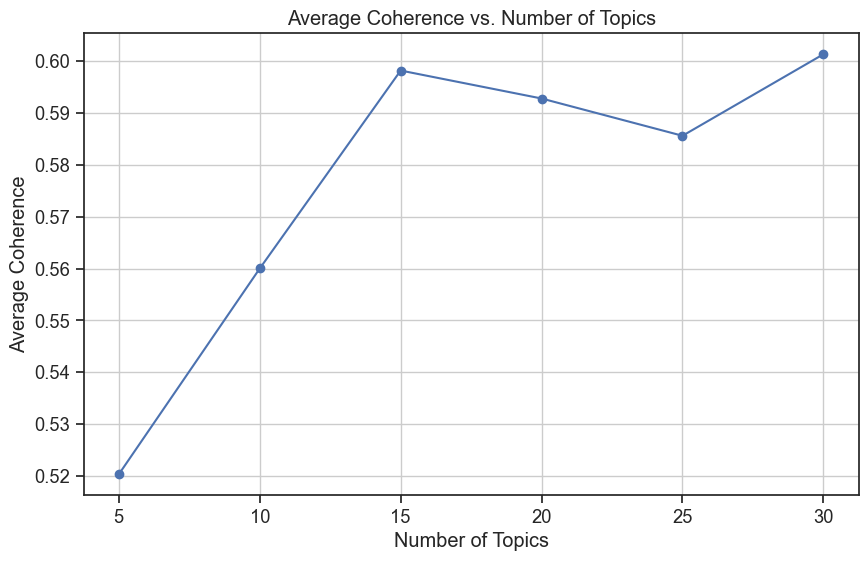

In [51]:
num_topics_list = [num_topics_5, num_topics_10, num_topics, num_topics_20, num_topics_25, num_topics_30]
coherence_scores = [average_coherence_5, average_coherence_10, average_coherence, average_coherence_20, average_coherence_25,average_coherence_30]
plot_avg_coherence(num_topics_list, coherence_scores)

### Q7. Topic distributions
Calculate the topic distributions for all tweets and get the top documents for some topics (between 2 and 5) that you think could be more representative of Sanders or Trump.

In [22]:
# Q7a (code)
topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]

from IPython.display import Markdown, display
import re

def make_md(string):
    display(Markdown(str(string)))

def get_top_docs(docs, topic_distributions, topic_index, n=5):

    sorted_data = sorted([(_distribution[topic_index], _document)
                          for _distribution, _document
                          in zip(topic_distributions, docs)], reverse=True)

    topic_words = topics[topic_index]

    make_md(f"### ✨Topic {topic_index}✨\n\n{topic_words}\n\n")
    print("---")

    for probability, doc in sorted_data[:n]:
        # Make topic words bolded
        for word in topic_words.split():
            if word in doc.lower():
                doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE)

        make_md(f'✨  \n**Topic Probability**: {probability}  \n**Document**: {doc}\n\n')

    return

In [56]:
# Display 6 documents for topic 0
get_top_docs(topics, topic_distributions, topic_index=0, n=6)

### ✨Topic 0✨

great vote total endorsement state strong military complete governor amendment



---


✨  
**Topic Probability**: 0.07942196726799011  
**Document**: workers pay tax women billion year wealth america wage million



✨  
**Topic Probability**: 0.007481907494366169  
**Document**: united states trade jobs china deal world american countries big



✨  
**Topic Probability**: 0.006248987279832363  
**Document**: health care people need americans must tax right working country



✨  
**Topic Probability**: 0.004699993412941694  
**Document**: trump must security president right american government people law want



✨  
**Topic Probability**: 0.0044257319532334805  
**Document**: trump president fbi russia collusion witch hunt mueller campaign schiff



✨  
**Topic Probability**: 0.004181713797152042  
**Document**: trump election court president **vote** supreme voting via fraud senate



In [64]:
# Display 6 documents for topic 3
get_top_docs(topics, topic_distributions, topic_index=3, n=6)

### ✨Topic 3✨

workers pay tax women billion year wealth america wage million



---


✨  
**Topic Probability**: 0.05836784094572067  
**Document**: trump election court president vote supreme voting via fraud senate



✨  
**Topic Probability**: 0.005781961139291525  
**Document**: united states trade jobs china deal world american countries big



✨  
**Topic Probability**: 0.004829170182347298  
**Document**: health care people need americans must **tax** right working country



✨  
**Topic Probability**: 0.0036321193911135197  
**Document**: trump must security president right american government people law want



✨  
**Topic Probability**: 0.0034201720263808966  
**Document**: trump president fbi russia collusion witch hunt mueller campaign schiff



✨  
**Topic Probability**: 0.003231596667319536  
**Document**: must war change people climate trump energy together stand world



Interpret the results above. Are there topics that have top tweets only by one politician? Why do you think these topics are more representative of one of the two politicians' views?

 I think these topics are more representative of one the politicians' views.
 
For Topic 0, the words ar include "great","vote", "total", "endorsement", "state", "strong", "military", "complete", "governor", "amendment".etc. These keywords emphasize national strength, electoral success, military prowess, and governmental authority. The mention of "amendment" might refer to discussions around constitutional rights, which are often highlighted in conservative agendas. So it is representative of Trump's political views.
 
For Topic 3, the words are "workers", "pay", "tax", "women", "billion", "year", "wealth", "america", "wage", "million".etc, which focus on economic issues, workers' rights, gender equality and wealth distribution. Given Sanders' consistent advocacy for economic reforms and social justice, Topic 3's keywords are close with his political ideology.

Although the topic distribution results suggest that Topic 0 is associated with documents mentioning "woman," "wealth," etc., and Topic 3 is linked to documents containing "Trump," "Russia," etc., it's important to note that this analysis does not account for the context of the tweets. Therefore, it doesn't directly indicate whether these discussions are conducted in support of or in criticism of the keywords mentioned. Moreover, given the opposing stances of the two political figures involved, it's possible that the content of these documents serves as criticism of the other position.

## Large scale analysis

### Q8. Create a random sample of the whole dataset and visualize the topic distributions for the sampled tweets

In [25]:
# Crete a sample of tweets

from random import sample

target_labels = sample(titles,100)

In [26]:
# Q8 (code)
# Create a heatmap using the random sample
# Tip: to display more than 20 tweets you have to change the values of `dim =` in sns.heatmap()
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='ticks', font_scale=1.2)
def plot_categories_by_topics_heatmap(labels,
                                      topic_distributions,
                                      topic_keys,
                                      output_path=None,
                                      target_labels=None,
                                      color_map = sns.cm.rocket_r,
                                      dim=None):

    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
          if not target_labels or _label in target_labels:
      
            for _topic_index, _probability in enumerate(_distribution[:len(topic_keys)]):
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Tweet': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Tweet',
                                     columns='Topic',
                                     values='Probability')
    df_norm_col=(df_wide-df_wide.mean())/df_wide.std()

    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_col, cmap=color_map)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    plt.show()


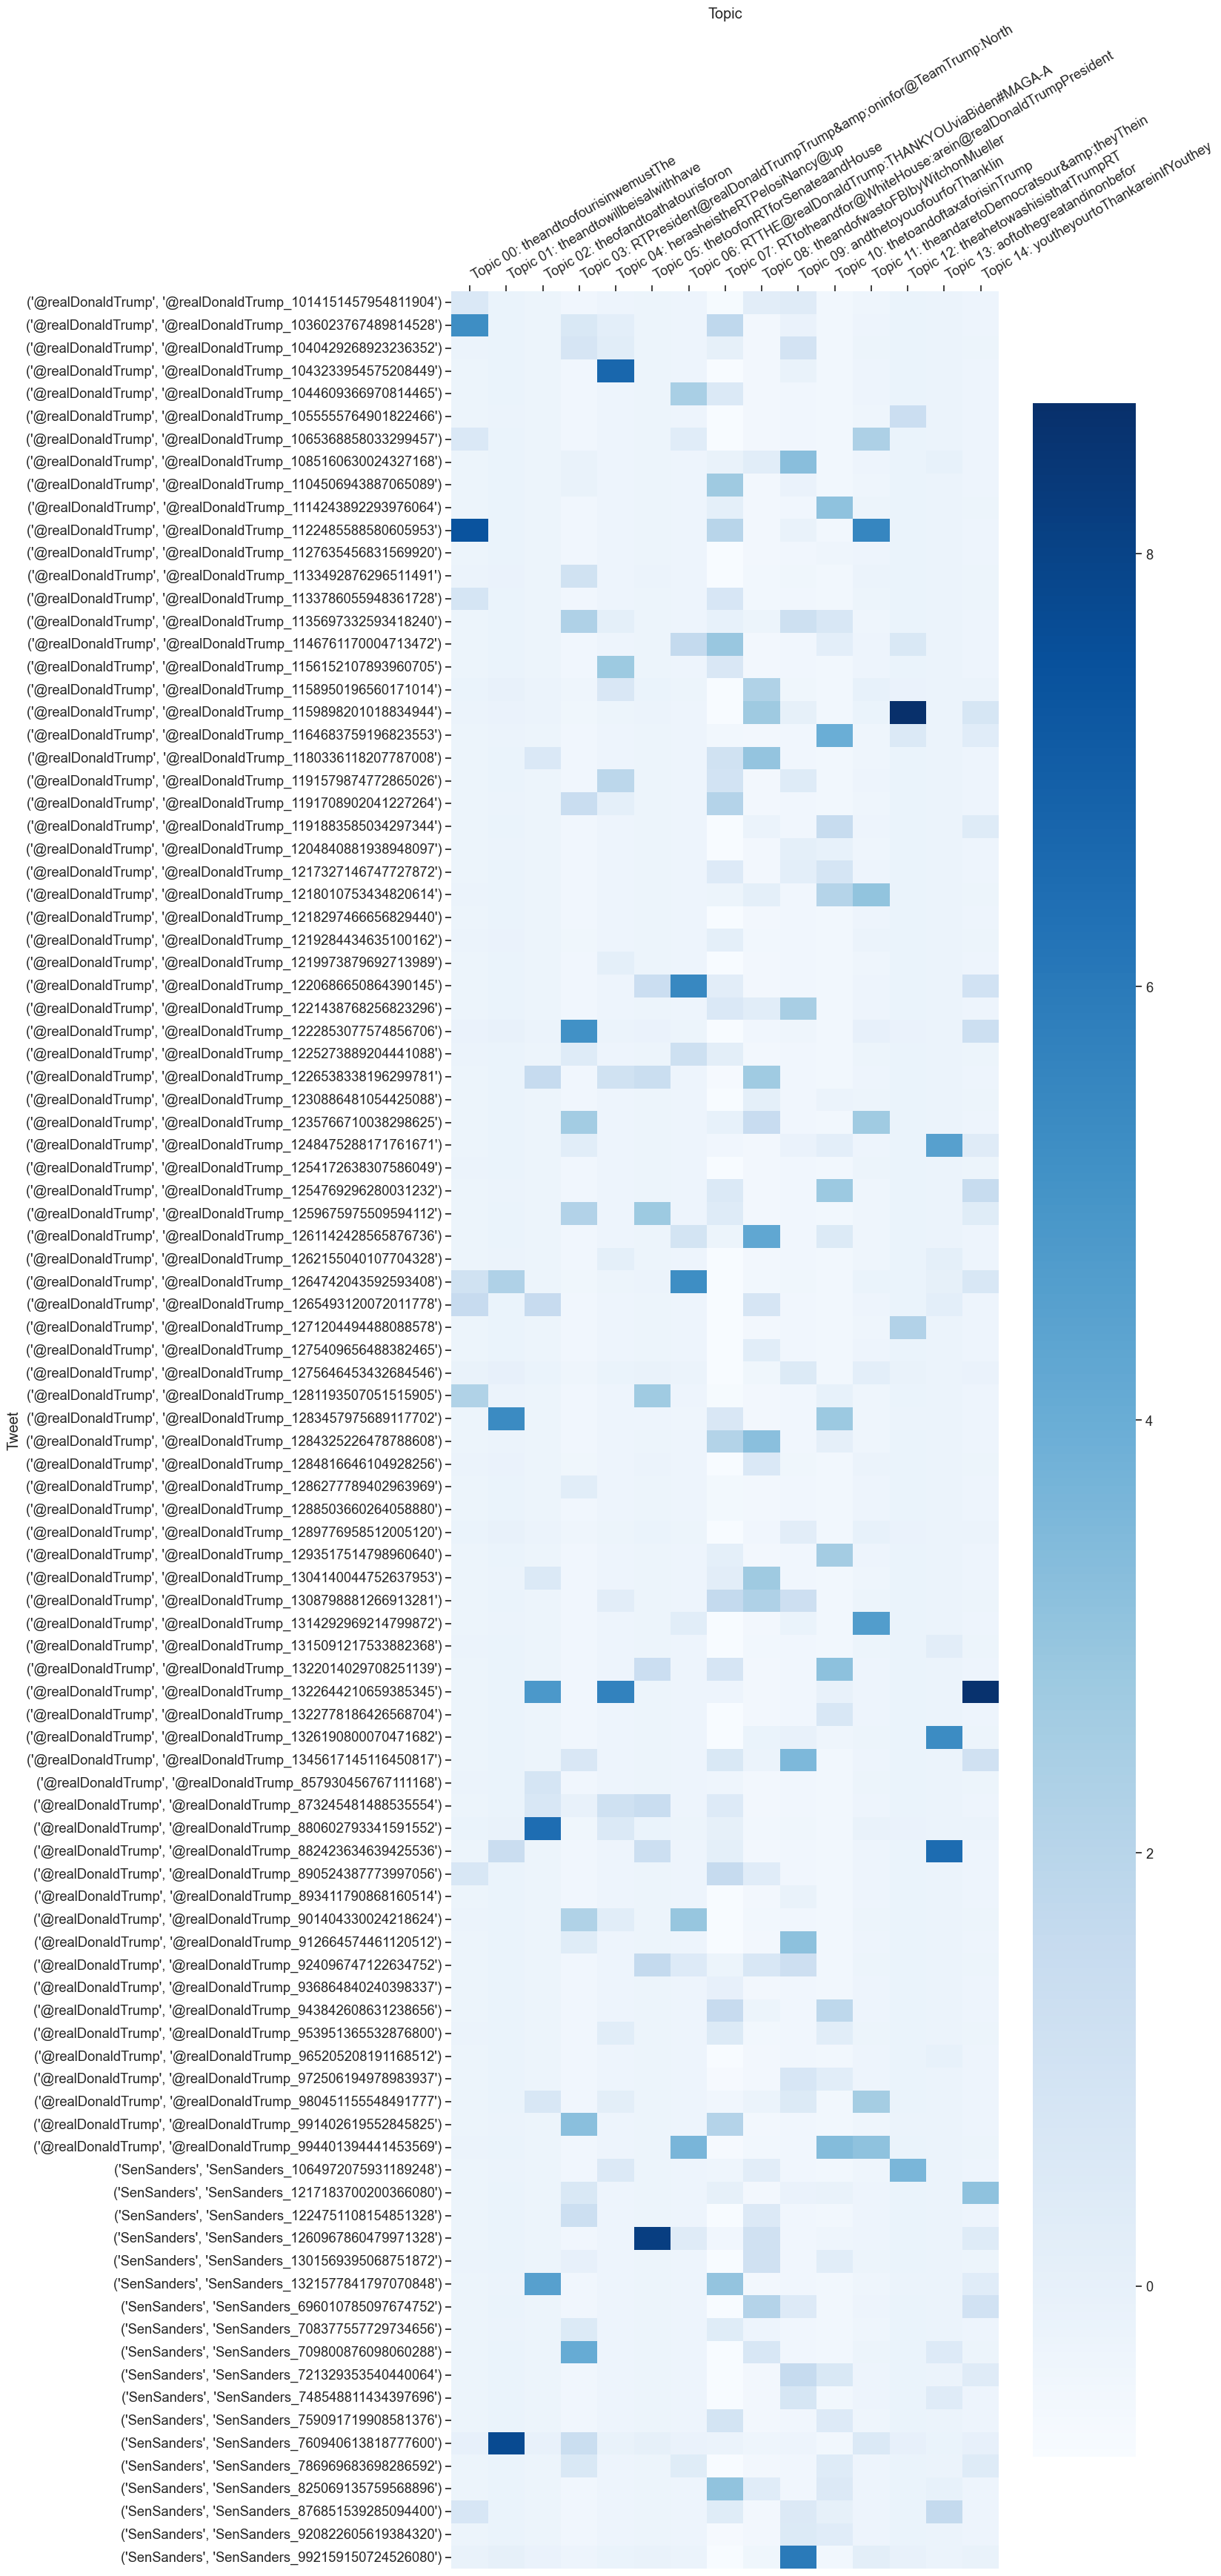

In [111]:
plot_categories_by_topics_heatmap(target_labels,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=target_labels,
                                  color_map = 'Blues',
                                 dim=(16,40))

### Q9. Interpret the heatmap
Do you see any pattern in the probability distributions of topics for each politician?

Are there topics that are more likely for one of the two politicians?

From the heatmap above, we can see that specific topics are not consistently associated with one politician or another), which suggests that there isn't a strong differentiation in topic distribution between the two politicians.

For example, even though Topic 9 is primarily associated with Sanders, the presence of some Trump tweets strongly related to this topic might indicate occasional overlap in the subjects addressed by both politicians.

Moreover, dataset contains significantly more tweets from Trump than from Sanders which caused skewed sample. As a result, the heatmap naturally show more data points for Trump. Skewed sample

### X2. Optional question 2
(This question is not compulsory, it only allows you to get an extra point)

Make the sample balanced, with 50 tweets by Trump and 50 by Sanders.

In [43]:
# X2 (code)
# Filter tweets by Trump and Sanders
trump_tweets = combined_df[combined_df['Username'] == '@realDonaldTrump'].sample(50, random_state=42)
sanders_tweets = combined_df[combined_df['Username'] == 'SenSanders'].sample(50, random_state=42)

# Concatenate the balanced samples
balanced_sample = pd.concat([trump_tweets, sanders_tweets])

# Shuffle the balanced sample
balanced_sample = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)


In [44]:
balanced_sample

,Username,TweetId,Title,Content
0,SenSanders,1093573599980634112,SenSanders_1093573599980634112,"Mr. Trump, you are dead wrong. This is not a ""..."
1,SenSanders,949398409676558336,SenSanders_949398409676558336,This is a health crisis that no one is talking...
2,SenSanders,1067152462493159424,SenSanders_1067152462493159424,The fact that we have a President of the Unite...
3,@realDonaldTrump,1087200167802163200,@realDonaldTrump_1087200167802163200,Curt Schilling deserves to be in the Baseball...
4,@realDonaldTrump,1313832140287750145,@realDonaldTrump_1313832140287750145,"RT @dbongino: It’s Wednesday, October 7th 202..."
...,...,...,...,...
95,SenSanders,1143187172125761536,SenSanders_1143187172125761536,My colleagues @RepJayapal and @Ilhan are joini...
96,SenSanders,893499521627561984,SenSanders_893499521627561984,Vermont's Green Mountain Power continues to le...
97,@realDonaldTrump,963031666150313984,@realDonaldTrump_963031666150313984,This will be a big week for Infrastructure. A...
98,SenSanders,1004750647445647360,SenSanders_1004750647445647360,I believe that we have become far too comforta...


### X3. Optional question 3
(This question is not compulsory, it only allows you to get an extra point)

Extend the analysis to all the tweets in the dataset.

In [ ]:
# X3 (code and words)
# Tip: plotting a heatmap for thousands of tweets is not practical.
# Make a comparison based on the numerical values in the `df_norm_col` dataframe (see Week 6 notebook)